<a href="https://colab.research.google.com/github/giulicrenna/data_science/blob/main/Estadistica_Descriptiva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
#para montar en drive
from google.colab import drive
import os
drive.mount('/content/gdrive')
# Establecer ruta de acceso en drive

print(os.getcwd())
os.chdir("/content/gdrive/My Drive")
! pip install pingouin
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels
from scipy import stats
from pingouin import pairwise_ttests #this is for performing the pairwise tests

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Inferencia estadistica ejemplo

In [3]:
bank = pd.read_csv("/content/gdrive/MyDrive/Instituto Crenna/csv/bank-full.csv")
print(bank.shape)
bank.head()

(45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


Las características relevantes que usaremos en este caso son:

1. **balance:** saldo bancario; variable clave de interés
2. **job:** el título del trabajo ("gerencia", "técnico", etc.)
3. **marital:** estado civil ("soltero", "casado" o "divorciado")
4. **education:** diferentes niveles de educación ("primaria", "secundaria", "terciaria", "desconocida")
5. **default:** el cliente predeterminado ("sí" o "no")
6. **loan:** el cliente obtuvo un préstamo ("sí" o "no")

In [4]:
bank.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000




El año pasado, el saldo promedio de toda la población de clientes del banco fue de \\$1341.12. ¿Cuánto más alto es el saldo promedio de la muestra este año? ¿Es esta diferencia significativa?

**Respuesta.**

In [5]:
bank['balance'].mean()

1362.2720576850766

Esta es una diferencia de \\$1362.27 - \\$1341.12 = \\$22.15. La dirección del banco cree que el comportamiento del consumidor podría haber cambiado ligeramente y que, en promedio, los clientes mantienen más dinero en su cuenta bancaria.

Sin embargo, esta diferencia podría deberse a una variación estadística debido a la variabilidad del muestreo. Necesitaríamos realizar una prueba más rigurosa para determinar si esta diferencia es realmente significativa después de tener en cuenta dicha variabilidad.

## Marco analítico para la prueba de hipótesis (20 min)

El procedimiento que usamos para ayudarnos a decidir si una diferencia entre la media $ \mu $ de una población y un valor de referencia $\mu_0$ es **estadísticamente significativa** se llama **prueba de hipótesis**. En nuestro contexto,
$\mu$ es el saldo bancario promedio de los clientes este año y $ \mu_0$ es su saldo bancario promedio el año pasado.

El primer paso es definir la hipótesis nula (a menudo indicada como $H_0$). Para nosotros, la hipótesis nula **siempre** corresponderá a la hipótesis de no cambio; es decir, el statu quo sigue siendo válido. Formalmente, esto se escribe como: $H_0:\mu=\mu_0$.

En nuestro caso, $H_0$ sería equivalente al plantear la hipótesis de que el saldo promedio para toda la población de clientes $\mu$ es el mismo que el saldo promedio del año pasado $\mu_0 =\$1341.12$. Deseamos probar si $H_0$ es incorrecto; es decir, si $\mu$ es diferente de $\mu_0 = \$ 1341.12$.

Antes de profundizar en el caso, piense en la siguiente pregunta:

### Pregunta: (5 min)

Suponga que usted es Ronald Fisher en la década de 1920 y descubriera la prueba de hipótesis por primera vez. ¿Cómo probaría la veracidad de la hipótesis nula $H_0$?

**Respuesta:** 

Podemos usar un enfoque similar al del sistema judicial en todo el mundo: *[Uno se considera inocente hasta que se demuestre lo contrario](https://en.wikipedia.org/wiki/Presumption_of_innocence)*. Aceptaremos la hipótesis nula a menos que encontremos suficiente evidencia en su contra. Nótese que este enfoque, como es el caso del sistema judicial, no es perfecto. Incluso si no encontramos evidencia que vaya en contra de la hipótesis nula, la hipótesis nula puede resultar errónea.

### Hipótesis alternativa (3 min)

In opposition to the null hypothesis, we define an alternative hypothesis (often indicated with $H_1$ or $H_a$) to challenge the status quo. We can have three different ways to define an alternative hypothesis:


1. $H_a: \mu \neq \mu_0$ (two-sided test)

2. $H_a: \mu > \mu_0$ (one-sided test)

3. $H_a: \mu < \mu_0$ (one-sided test)

La prueba estadística nos ayudará a decidir si hay suficiente evidencia para rechazar la hipótesis nula a favor de una alternativa.

### Realización de una prueba de hipótesis (3 min)

Volviendo a nuestro caso, supongamos que deseamos realizar una prueba estadística para evaluar la hipótesis de gestión:

$$ H_0: \mu= 1341.12$$
$$ H_a: \mu \neq 1341.12$$

Hay dos resultados posibles para esta prueba: (1)Concluimos que $H_0$ es falso y decimos que **rechazamos $H_0$**. En este caso concluiremos que existe evidencia estadística para la alternativa $H_a$ y que el saldo bancario de los clientes este año es de hecho diferente de 1341,12 USD. O (2) **no rechazamos $H_0$**. En este caso, concluimos que no hay suficiente evidencia estadística para decir con certeza que $H_0$ es falso. **Observe que en el segundo caso no podemos decir que la hipótesis original sea verdadera.** (De hecho, no existe ninguna prueba que le diga que una hipótesis es verdadera. ¿Por qué cree que es así?)

Podemos usar [Student's](https://www.guinness-storehouse.com/content/pdf/archive-factsheets/general-history/wsgosset-and-students-t-test.pdf) $t$-[prueba](https://en.wikipedia.org/wiki/Student's_t-test) para realizar una prueba de hipótesis para la media de una sola población. El siguiente comando nos permite ejecutar esta prueba:

In [6]:
stats.ttest_1samp(bank['balance'], popmean=1341.12)

Ttest_1sampResult(statistic=1.477137017325908, pvalue=0.13964587808442475)

**Nota:** Si la alternativa es unilateral, diga $ H_a: \mu>\mu_0$ o $H_a:\mu <\mu_0$. Luego, simplemente ejecute la prueba de dos lados y luego divida el valor $p$-por la mitad.

In [7]:
T,p = stats.ttest_1samp(bank['balance'], popmean=1341.122)
p_value = p/2
p_value

0.06984165666422609

### ¿Son los medios del préstamo y los grupos no crediticios significativamente diferentes? (5 min)

Nos gustaría probar estadísticamente si las medias de los dos grupos son diferentes entre sí; es decir, si la diferencia entre el saldo medio en los grupos con un préstamo ($\mu_1 $) es diferente del saldo medio en el grupo sin préstamo ($\mu_2$). El procedimiento de prueba que describimos también se puede utilizar para responder a esta pregunta:

$$ H_0: \mu_1=\mu_2$$
$$H_a: \mu_1 \neq \mu_2$$

Obtenemos lo siguiente

In [8]:
loans=bank[bank.loan=="yes"].balance
no_loans=bank[bank.loan=="no"].balance

statistic, pvalue = stats.ttest_ind(loans,no_loans, equal_var=False)
print('Estadistico:',round(statistic,2),'p-valor:', round(pvalue,2))

Estadistico: -25.18 p-valor: 0.0


# Intervalos de confianza

In [9]:
from scipy.stats import t
m = bank.balance.mean()
s = bank.balance.std()
dof = len(bank.balance)-1
confianza = 0.95
t_crit = np.abs(t.ppf((1-confianza)/2,dof)) # Valor critico
print(t_crit)
(m-s*t_crit/np.sqrt(len(bank.balance)), m+s*t_crit/np.sqrt(len(bank.balance))) # Intervalo

1.960016458188857


(1334.2053443734276, 1390.3387709967255)

In [10]:
loans.mean(),no_loans.mean()

(774.3099116510215, 1474.4536307846288)

In [11]:
import numpy as np, statsmodels.stats.api as sms
X1, X2 = bank[bank.loan=="yes"].balance,bank[bank.loan=="no"].balance
cm = sms.CompareMeans(sms.DescrStatsW(X1), sms.DescrStatsW(X2))
print(cm.tconfint_diff(usevar='unequal'))

(-754.6437941384797, -645.6436441287349)


# Desafio generico (No ver hasta el final de clase)

## Parte 1, 2 y 3: Agregar datos de varias empresas

Hasta ahora, solo hemos analizado los datos de una de nuestras cinco empresas. Sigamos adelante y combinemos los cinco archivos CSV para analizar las cinco empresas juntas. Esto también reducirá la cantidad de trabajo de programación requerido, ya que el código se compartirá entre las cinco empresas.

Una forma de realizar esta tarea de agregación es utilizar el método ```pd.concat ()``` de ```pandas```. Una entrada en este método puede ser una lista de DataFrames que le gustaría concatenar. Usaremos un bucle for para recorrer cada símbolo bursátil, cargar el archivo CSV correspondiente y luego agregar el resultado a una lista que luego se agrega usando ```pd.concat()```. Echemos un vistazo a cómo se hace esto.

In [15]:
print("Definiendo los simbolos de stock")
symbol_data_to_load = ['D','EXC','NEE (1)','SO','DUK (1)']
list_of_df = []

# Ciclo sobre simbolos
#llenar la lsita de dataframes
print(" --- Inicio de Loop --- ")
for i in symbol_data_to_load:
    print("Procesando Simbolo: " + i)
    temp_df = pd.read_csv("/content/gdrive/MyDrive/Instituto Crenna/csv/" + i +'.csv',sep=',')
    temp_df['Volume_Millions'] = temp_df['Volume'] / 1000000.0
    temp_df['Symbol'] = i # Agregar nueva columna con el simbolo 
    list_of_df.append(temp_df)

print(" --- Completado loop simbolos --- ")
    
# Combinar en un Dataframe unico usando concat
#permite pegar los dataframes de la lista
print("Agregando la data")
agg_df = pd.concat(list_of_df, axis=0)

# Agregar estadisticas de retorno y volatilidad
# es mas rápido agregarlo al dataframe que a cada uno de los registros
print('Calculando estadisticas finales')
agg_df['VolStat'] = (agg_df['High'] - agg_df['Low']) / agg_df['Open']
agg_df['Return'] = (agg_df['Close'] / agg_df['Open']) - 1.0

print("agg_df DataFrame dimension (filas, columnas): ")
print(agg_df.shape)

print("Head del DataFrame agg_df: ")
agg_df.head()

#print("agg_df['Symbol'].unique()")

Definiendo los simbolos de stock
 --- Inicio de Loop --- 
Procesando Simbolo: D
Procesando Simbolo: EXC
Procesando Simbolo: NEE (1)
Procesando Simbolo: SO
Procesando Simbolo: DUK (1)
 --- Completado loop simbolos --- 
Agregando la data
Calculando estadisticas finales
agg_df DataFrame dimension (filas, columnas): 
(6295, 11)
Head del DataFrame agg_df: 


,Date,Open,High,Low,Close,Adj Close,Volume,Volume_Millions,Symbol,VolStat,Return
0,2014-07-28,69.750000,71.059998,69.750000,70.879997,57.963978,1806400,1.8064,D,0.018781,0.016201
1,2014-07-29,70.669998,70.980003,69.930000,69.930000,57.187099,2231100,2.2311,D,0.014858,-0.010471
2,2014-07-30,70.000000,70.660004,68.400002,68.970001,56.402020,2588900,2.5889,D,0.032286,-0.014714
3,2014-07-31,68.629997,68.849998,67.580002,67.639999,55.314388,3266900,3.2669,D,0.018505,-0.014425
4,2014-08-01,67.330002,68.410004,67.220001,67.589996,55.273487,2601800,2.6018,D,0.017674,0.003861


In [16]:
agg_df.Symbol.unique()

array(['D', 'EXC', 'NEE (1)', 'SO', 'DUK (1)'], dtype=object)

# Parte 4

In [17]:
agg_df1=agg_df[['Date','Symbol','VolStat']].groupby(by=['Date','Symbol']).mean().reset_index()
agg_df1['Date']=pd.to_datetime(agg_df1['Date']) 
agg_df1.head()

,Date,Symbol,VolStat
0,2014-07-28,D,0.018781
1,2014-07-28,DUK (1),0.017051
2,2014-07-28,EXC,0.023878
3,2014-07-28,NEE (1),0.016858
4,2014-07-28,SO,0.018153


Text(0.5, 1.0, 'Comparacion de volatilidad relativa vs Fecha')

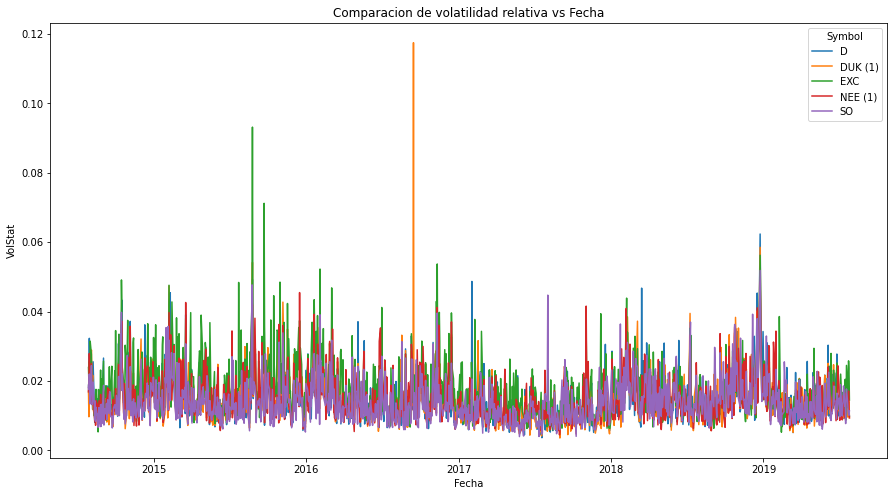

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
sns.lineplot(x= agg_df1.Date, y= agg_df1.VolStat, hue=agg_df1.Symbol)
plt.xlabel('Fecha')
plt.ylabel('VolStat')
plt.title('Comparacion de volatilidad relativa vs Fecha')

In [19]:
agg_df2=agg_df[['Date','Symbol','Return']].groupby(by=['Date','Symbol']).mean().reset_index()
agg_df2['Date']=pd.to_datetime(agg_df1['Date']) 
agg_df2.head()

,Date,Symbol,Return
0,2014-07-28,D,0.016201
1,2014-07-28,DUK (1),0.014732
2,2014-07-28,EXC,0.017192
3,2014-07-28,NEE (1),0.011272
4,2014-07-28,SO,0.016585


Text(0.5, 1.0, 'Comparacion de retorno vs Fecha')

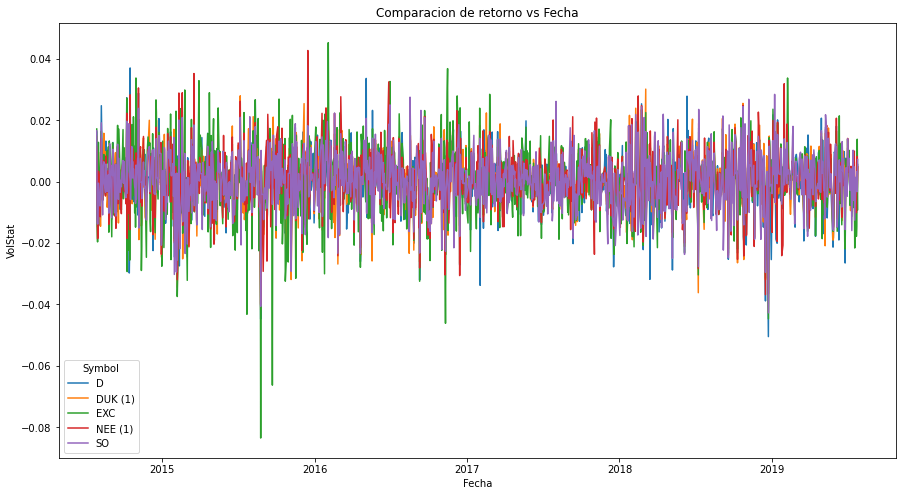

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
sns.lineplot(x= agg_df2.Date, y= agg_df2.Return, hue=agg_df2.Symbol)
plt.xlabel('Fecha')
plt.ylabel('VolStat')
plt.title('Comparacion de retorno vs Fecha')

Text(0.5, 1.0, 'Comparacion de retorno vs Fecha')

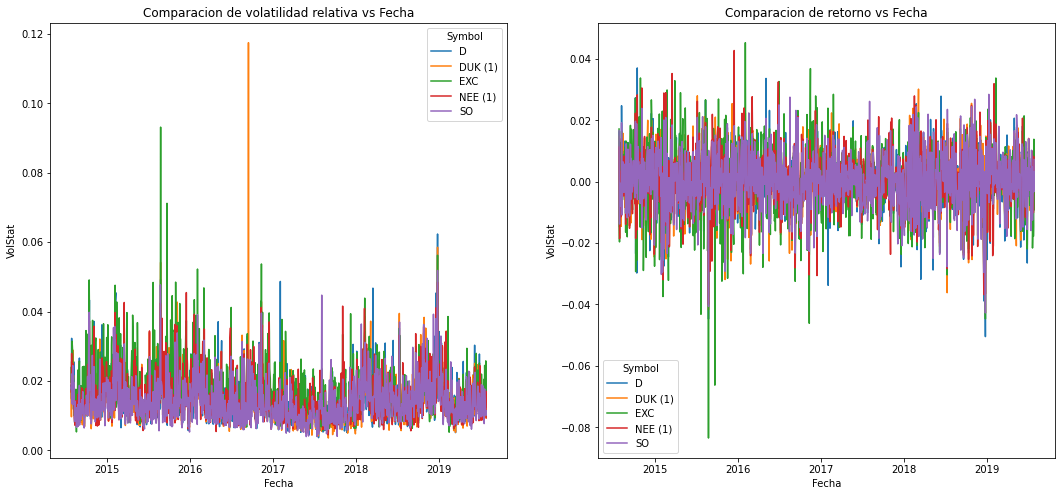

In [21]:
plt.figure(figsize=(18,8))
plt.subplot(121)
sns.lineplot(x= agg_df1.Date, y= agg_df1.VolStat, hue=agg_df1.Symbol)
plt.xlabel('Fecha')
plt.ylabel('VolStat')
plt.title('Comparacion de volatilidad relativa vs Fecha')
plt.subplot(122)
sns.lineplot(x= agg_df2.Date, y= agg_df2.Return, hue=agg_df2.Symbol)
plt.xlabel('Fecha')
plt.ylabel('VolStat')
plt.title('Comparacion de retorno vs Fecha')

Donde invertirian? 


Cada acción exhibe un **agrupamiento de volatilidad**: los períodos de alta volatilidad tienden a agruparse. Cada una de las acciones experimentó una alta volatilidad en momentos relativamente similares, lo que sugiere que algún factor de mercado más amplio puede estar afectando al sector energético.
